# AB Testing Example with Cookie Cats Data
https://www.kaggle.com/code/ekrembayar/a-b-testing-step-by-step-hypothesis-testing/notebook

The data is from 90,189 players that installed the game while the AB-test was running. 

The variables are:

* userid - a unique number that identifies each player.
* version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
* sum_gamerounds - the number of game rounds played by the player during the first week after installation
* retention_1 - did the player come back and play 1 day after installing?
* retention_7 - did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

df = pd.read_csv('cookie_cats.csv')
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


A few outliers appear to be influencing the sum_gamerounds data. We remove the one observation greater than 5000 gamerounds. 

In [12]:
print(f"Number of Total Observations: {df.shape[0]}")
print(f"Number of Observations over 1000: {df.loc[df.sum_gamerounds > 1000].shape[0]}")
print(f"Number of Observations over 2000: {df.loc[df.sum_gamerounds > 2000].shape[0]}")
print(f"Number of Observations over 5000: {df.loc[df.sum_gamerounds > 5000].shape[0]}")


Number of Total Observations: 90188
Number of Observations over 1000: 115
Number of Observations over 2000: 9
Number of Observations over 5000: 0


In [10]:
df = df[df.sum_gamerounds < 5000].reset_index()

<AxesSubplot:xlabel='sum_gamerounds', ylabel='Count'>

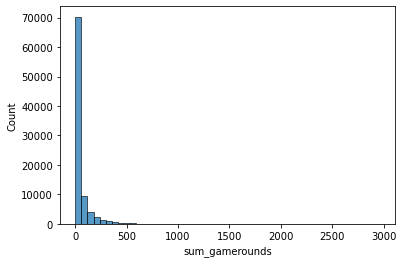

In [11]:
sns.histplot(df.sum_gamerounds, bins = 50)

[Text(0.5, 1.0, 'Number of Gamerounds Comparison A vs. B'),
 Text(0.5, 0, 'Sample Size'),
 Text(0, 0.5, 'sum_gamerounds')]

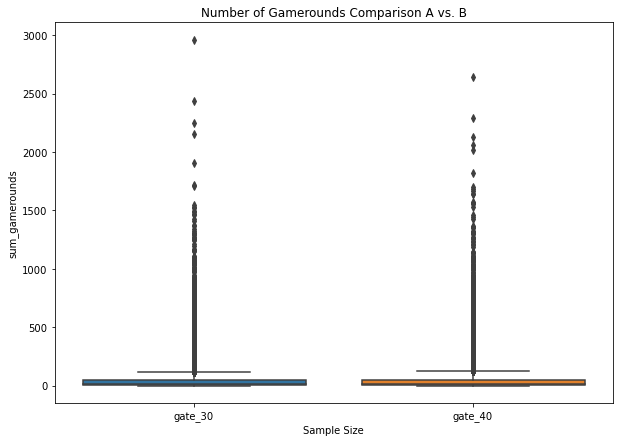

In [14]:
# games_30 = df.loc[df.version == 'gate_30']
# games_40 = df.loc[df.version == 'gate_40']

fig, axes = plt.subplots(figsize = (10,7))
sns.boxplot(data=df, x='version', y='sum_gamerounds', ax = axes).set(title='Number of Gamerounds Comparison A vs. B', xlabel='Sample Size', ylabel='sum_gamerounds')

From an initial glance, a large difference cannot be observed. 

# Frequentist Approach: Two-Sided T-test

**Business Question:**
> Does changing the gate_level from 30 to 40 positively impact the number of game rounds a player will play during the first week after installation?

**Experiment Parameters:**
* Significance Level ($\alpha$): **5%**
* Power ($1-\beta$): **80%**
* Minimum Detectable Effect (MDE): **10 gamerounds**
* Two-Sided Test

**Get the Appropriate Sample Size**


**Experiment Design:**
$$
\begin{align} 
H_0:& \mu_1 = \mu_2 \\
H_1:& \mu_1 \ne \mu_2 \end{align}
$$


In [19]:
from scipy import stats as st
from scipy.stats import norm


sample_A = df[df.version == 'gate_30'].sum_gamerounds
sample_B = df[df.version == 'gate_40'].sum_gamerounds

t_stat, pvalue = st.ttest_ind(sample_A, sample_B, equal_var = False)
print(f"P-value on the t-test is: {pvalue}")
print(f"The statistic value is: {t_stat} and critical bounds at the 5% significance level are: ({norm.ppf(0.025).round(decimals=6)}, {norm.ppf(0.975).round(decimals=6)})")


P-value on the t-test is: 0.9494686215464458
The statistic value is: 0.06337426312892294 and critical bounds at the 5% significance level are: (-1.959964, 1.959964)


Our p-value is insignificant, and therefore we cannot reject the null hypothesis. 

Therefore, our conclusion from the A/B test above would be that the gate level does not materially affect the number of gamerounds a player chooses to play.  

# Bayesian Test
Bayesian tests are preferable to Frequentist tests when we do not know if we have enough samples to achieve adequate statistical pwoer. 

**Business Question:**
> Does changing the gate_level from 30 to 40 affect the retention of the player?

Let's say that we select our response variable to be **retention_1**, which has two possible outcomes {True, False}. Thus, **retention_1** can be modeled as a Bernoulli(p) random variable. 

The outcomes of the Bernoulli(p) trials, which we can say are:
$$Y = \sum X_i$$
Follows a Binomial(n,p) distribution:
$$
f(y|p) =  \binom{n}{x}p^y (1-p)^{n-y}
$$

And we also note that the Binomial distribution converges in distribution towards a normal distribution as $n \to \infty$

In [26]:
def get_binom(sample, N):
    sample_N = [np.sum(np.random.choice(sample, size=N)) for x in range(10000)]
    return sample_N

<AxesSubplot:ylabel='Count'>

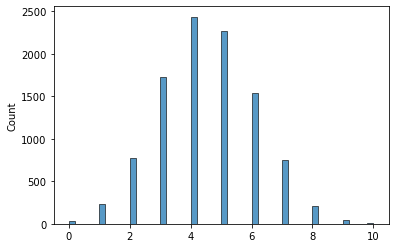

In [60]:
sample_A = df[df.version == 'gate_30'].retention_1
sample_B = df[df.version == 'gate_40'].retention_1

temp = get_binom(sample_A, 10)
sns.histplot(temp, bins = 50)

In general, we want to know if the parameter value for $p$ is significantly different between samples A and B, for an experiment in which the outcomes are Bernoulli. 

The steps in a Bernoulli experiment are one again:
1. Choose Prior
2. Calculate Posterior Distribution

The common choice for the prior distribution on $p$ is the Beta distribution:
$$
\begin{align}
\pi(p) &= \beta(\alpha,\beta) \\
&= \dfrac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}p^{\alpha-1}(1-p)^{\beta-1}
\end{align}
$$

And if we choose this prior, then with the Binomial(n,p) sampling distribution, we would retrieve a posterior distribution for $p$ following $beta(y+\alpha, n-y+\beta)$:

$$
\begin{align}
\pi(p|y) &= \dfrac{\left[ \binom{n}{y}p^y (1-p)^{n-y} \right] \left[\dfrac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}p^{\alpha-1}(1-p)^{\beta-1} \right]}{f(y)} 
\end{align}
$$

Where $f(y)$ is the marginal distribution of Y:

$$
\begin{align}
f(y) &= \int^{1}_{0} f(y,p)dp \\
&= \binom{n}{y} \dfrac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} \dfrac{\Gamma(y+\alpha) \Gamma(n-y+\beta)}{\Gamma(n+\alpha + \beta)}
\end{align}
$$

Which is also recognized as the beta-binomial distribution. The posterior distribution therefore simplifies to:

$$
\begin{align}
\pi(p|y) &= \dfrac{f(y,p)}{f(y)} \\
&= \dfrac{\Gamma(n+\alpha+\beta)}{\Gamma(y+\alpha)\Gamma(n-y+\beta)}p^{y+\alpha-1}(1-p)^{n-y+\beta-1}
\end{align}
$$

Which again is precisely the distribution for $beta(y+\alpha, n-y+\beta)$

## The Bayes Experiment
So lets say we chose a beta distribution for our A/B test here. To make the conservative choice, we go with {$\alpha=2.0, \beta=2.0$}, which we can see below is centered at 0.5.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/pyt

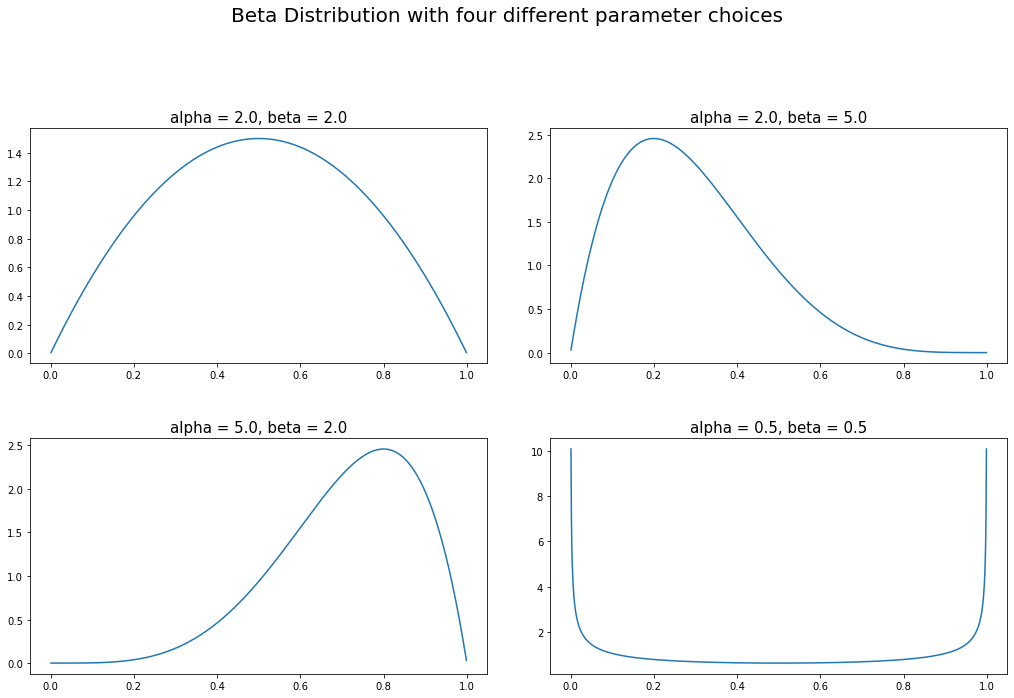

In [54]:
from scipy.stats import beta
a, b = 2.0, 2.0
x = np.linspace(0.001, 0.999, 1000)

fig, axes = plt.subplots(2, 2, figsize = (15,10))
sns.lineplot(x, beta.pdf(x, 2.0, 2.0), ax = axes[0,0])
sns.lineplot(x, beta.pdf(x, 2.0, 5.0), ax = axes[0,1])
sns.lineplot(x, beta.pdf(x, 5.0, 2.0), ax = axes[1,0])
sns.lineplot(x, beta.pdf(x, 0.5, 0.5), ax = axes[1,1])


plt.suptitle(t="Beta Distribution with four different parameter choices", fontsize = 20, va='bottom')
axes[0,0].set_title("alpha = 2.0, beta = 2.0", fontsize = 15)
axes[0,1].set_title("alpha = 2.0, beta = 5.0", fontsize = 15)
axes[1,0].set_title("alpha = 5.0, beta = 2.0", fontsize = 15)
axes[1,1].set_title("alpha = 0.5, beta = 0.5", fontsize = 15)
plt.tight_layout(pad = 4)

# Update Posterior Distributions

Say that we chose the parameters ${\alpha=2.0, \beta=2.0}$ and ran the A/B test experiment for 500 samples. 

We would then update our posterior distributions:

In [96]:
sample_500_A = np.random.choice(sample_A, size=500)
sample_500_B = np.random.choice(sample_B, size=500)

# New alpha, beta values for posterior distribution of sample A
posterior_alpha_A = 2.0 + np.sum(sample_500_A)
posterior_beta_A = 2.0 + 500 - np.sum(sample_500_A)

# New alpha, beta values for posterior distribution of sample B
posterior_alpha_B = 2.0 + np.sum(sample_500_B)
posterior_beta_B = 2.0 + 500 - np.sum(sample_500_B)

Text(0.5, 1.0, 'Posterior Distribution after 500 observations each of A and B')

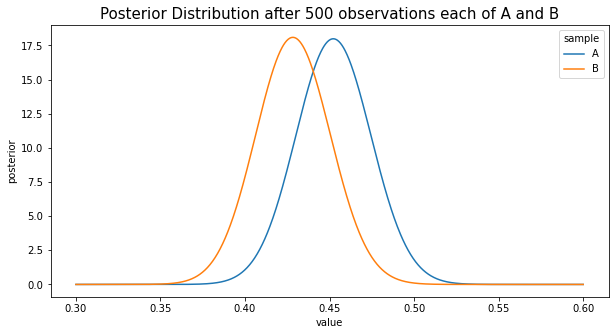

In [152]:
from scipy.stats import beta
x = np.linspace(0.3, 0.6, 1000)

plt.figure(figsize=(10,5))
plot_df = pd.concat(axis=0, ignore_index=True, objs= [
    pd.DataFrame.from_dict({'value': x, 'posterior': beta.pdf(x, posterior_alpha_A, posterior_beta_A), 'sample': 'A'}),
    pd.DataFrame.from_dict({'value': x, 'posterior': beta.pdf(x, posterior_alpha_B, posterior_beta_B), 'sample': 'B'})
])

sns.lineplot(x='value', y='posterior', hue='sample', data=plot_df).set_title('Posterior Distribution after 500 observations each of A and B', fontsize=15)

Try repeating this with increasing sample sizes...

In [81]:
def get_posterior_params(N, sample, a=2.0, b=2.0):
    y = np.random.choice(sample, size=N)
    posterior_alpha = a + np.sum(y)
    posterior_beta = b + N - np.sum(y)
    return posterior_alpha, posterior_beta

Text(0.5, 1.0, '5000 samples')

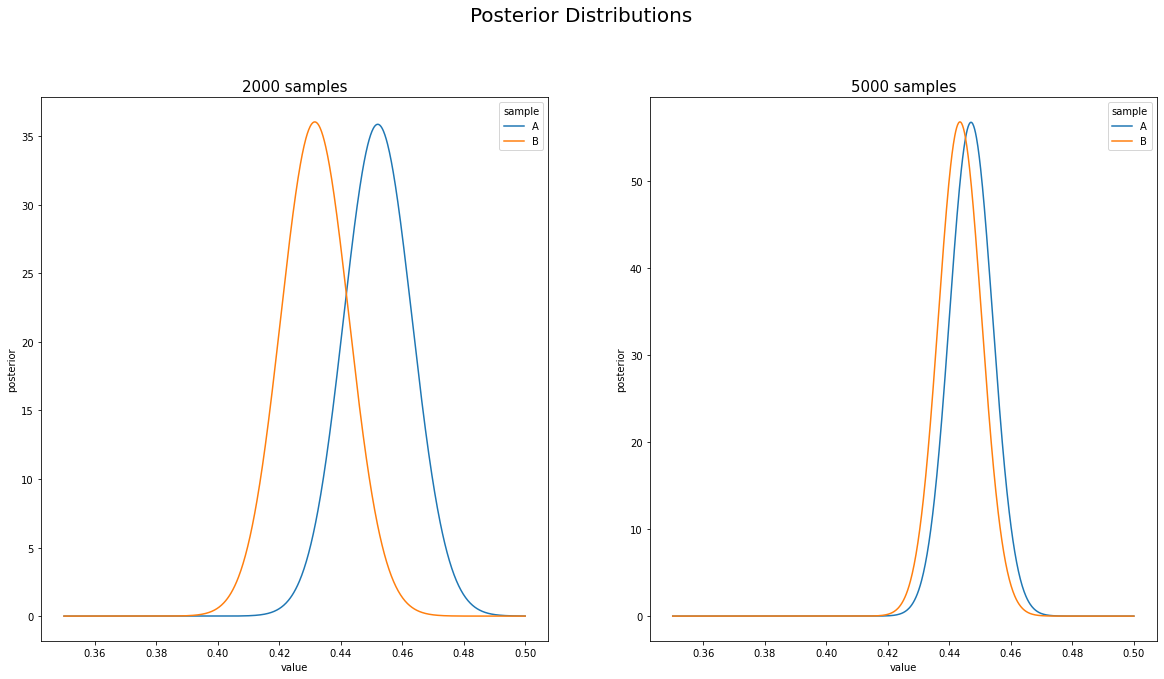

In [143]:
from scipy.stats import beta
x = np.linspace(0.35, 0.5, 1000)
fig, axes = plt.subplots(1, 2, figsize = (20,10))

# Use alpha, beta values obtained from the 500 sample run
alpha_A_2000, beta_A_2000 = get_posterior_params(1500, sample_A, a = posterior_alpha_A, b = posterior_beta_A)
alpha_B_2000, beta_B_2000 = get_posterior_params(1500, sample_B, a = posterior_alpha_B, b = posterior_beta_B)

plot_df1 = pd.concat(axis=0, ignore_index=True, objs= [
    pd.DataFrame.from_dict({'value': x, 'posterior': beta.pdf(x, alpha_A_2000, beta_A_2000), 'sample': 'A'}),
    pd.DataFrame.from_dict({'value': x, 'posterior': beta.pdf(x, alpha_B_2000, beta_B_2000), 'sample': 'B'})
])

# Use alpha, beta values obtained from the 1000 sample run
alpha_A_5000, beta_A_5000 = get_posterior_params(3000, sample_A, a = alpha_A_2000, b = beta_A_2000)
alpha_B_5000, beta_B_5000 = get_posterior_params(3000, sample_B, a = alpha_B_2000, b = beta_B_2000)

plot_df2 = pd.concat(axis=0, ignore_index=True, objs= [
    pd.DataFrame.from_dict({'value': x, 'posterior': beta.pdf(x, alpha_A_5000, beta_A_5000), 'sample': 'A'}),
    pd.DataFrame.from_dict({'value': x, 'posterior': beta.pdf(x, alpha_B_5000, beta_B_5000), 'sample': 'B'})
])

sns.lineplot(x='value', y='posterior', hue='sample', data=plot_df1, ax = axes[0])
sns.lineplot(x='value', y='posterior', hue='sample', data=plot_df2, ax = axes[1])

plt.suptitle(t="Posterior Distributions", fontsize = 20, va='bottom')
axes[0].set_title("2000 samples", fontsize = 15)
axes[1].set_title("5000 samples", fontsize = 15)